Step 1: Download & Load UCI HAR Dataset

In [6]:
import pandas as pd
import numpy as np
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Load dataset
train_X_path = r"UCI HAR Dataset/train/X_train.txt"
train_y_path = r"UCI HAR Dataset/train/y_train.txt"
test_X_path = r"UCI HAR Dataset/test/X_test.txt"
test_y_path = r"UCI HAR Dataset/test/y_test.txt"

X_train = pd.read_csv(train_X_path, sep=r'\s+', header=None)
y_train = pd.read_csv(train_y_path, sep=r'\s+', header=None).values.ravel() - 1  # Shift labels to start from 0
X_test = pd.read_csv(test_X_path, sep=r'\s+', header=None)
y_test = pd.read_csv(test_y_path, sep=r'\s+', header=None).values.ravel() - 1  # Shift labels to start from 0

# Reshape for RNN input (samples, timesteps, features)
X_train = X_train.values.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.values.reshape(X_test.shape[0], 1, X_test.shape[1])

print("✅ Data Loaded & Reshaped:", X_train.shape, y_train.shape)

✅ Data Loaded & Reshaped: (7352, 1, 561) (7352,)


The above output indicate that the 7352 samples were successfully loaded with each sample having 561 features such as accelerometer and gyroscope sensor readings. Also the dataset was reshaped to the format (samples, timesteps, features) which is the format for RNN.

Step 2: Define the two RNN models

In [7]:
# Define GRU Model with Optimizations
def create_gru_model(units=128, dropout_rate=0.4, learning_rate=0.0005):
    model = Sequential([
        Input(shape=(1, 561)),  # Explicit input layer
        GRU(units, return_sequences=False),
        Dropout(dropout_rate),
        Dense(64, activation='relu'),
        Dense(6, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Define SimpleRNN Model with Optimizations
def create_simplernn_model(units=128, dropout_rate=0.4, learning_rate=0.0005):
    model = Sequential([
        Input(shape=(1, 561)),  # Explicit input layer
        SimpleRNN(units, return_sequences=False),
        Dropout(dropout_rate),
        Dense(64, activation='relu'),
        Dense(6, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

Here two models of RNN is used, first is the baseline model, that is SimpleRnn, second is the GRU model. GRU is ideal it is computationally faster and also it is efficient for time series sensor data whereas Simple RNN is lightweight and fast.

 Step 3: Train Both Models

In [8]:
# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train GRU model
gru_model = create_gru_model()
print("\n🚀 Training Optimized GRU Model...")
gru_history = gru_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Train SimpleRNN model
simplernn_model = create_simplernn_model()
print("\n🚀 Training Optimized SimpleRNN Model...")
simplernn_history = simplernn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])



🚀 Training Optimized GRU Model...
Epoch 1/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.6329 - loss: 0.9474 - val_accuracy: 0.9097 - val_loss: 0.2578
Epoch 2/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9134 - loss: 0.2292 - val_accuracy: 0.9454 - val_loss: 0.1575
Epoch 3/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9374 - loss: 0.1533 - val_accuracy: 0.9301 - val_loss: 0.1666
Epoch 4/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9529 - loss: 0.1233 - val_accuracy: 0.9471 - val_loss: 0.1370
Epoch 5/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9618 - loss: 0.0927 - val_accuracy: 0.9471 - val_loss: 0.1381
Epoch 6/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9660 - loss: 0.0933 - val_accuracy: 0.9444 - val_loss: 0.1501
Epoch 7/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9733 - loss: 0.0787 - val_accuracy: 0.9508 - val_loss: 0.1266
Epoch 8/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accurac

For training GRU models, it started at 61.61% accuracy and jumped rapidly, reaching 97.44% in the last epoch. The best validation accuracy recorded was 95.15%, whereas validation loss stabilized at 0.1413, showing an effective balance between learning and generalization. The minimal fluctuation in validation loss denotes slight overfitting, but overall, GRU performed perfectly.

For SimpleRNN model, accuracy was 58.86% in early training that rose up to 97.64% for the final epoch. Validation accuracy was 94.47%, just lower than GRU, and validation loss fluctuated between 0.1707. SimpleRNN performed well, but it had higher validation loss and mild overfitting compared to GRU, hence GRU is the better model for this dataset.

Overall, both models were successful in learning complex patterns from the UCI HAR dataset, with GRU demonstrating better generalization than SimpleRNN. Early stopping implementation ensured that training was terminated at the appropriate time to prevent overfitting too much. Further fine-tuning, such as adjusting batch size or trying bidirectional GRU layers, would still enhance performance.

 Step 4: Evaluate the Models

In [9]:
# Evaluate models
gru_loss, gru_acc = gru_model.evaluate(X_test, y_test)
simplernn_loss, simplernn_acc = simplernn_model.evaluate(X_test, y_test)

print(f"\n🔹 Optimized GRU Model Accuracy: {gru_acc:.4f}")
print(f"🔹 Optimized SimpleRNN Model Accuracy: {simplernn_acc:.4f}")


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9423 - loss: 0.1345
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9423 - loss: 0.1441

🔹 Optimized GRU Model Accuracy: 0.9508
🔹 Optimized SimpleRNN Model Accuracy: 0.9494


After first epoch, the accuracy is 94.25% whereas in second epoch its increased to 94.72% and the loss is also reduced in second epich comparatively which shows that the model is improving in terms of error. Although the performance of both models are good, the SimpleRNN has outperformed the GRU by a small margin in terms of accuracy on the test data.

Step 5: Visualizing the Training Performance

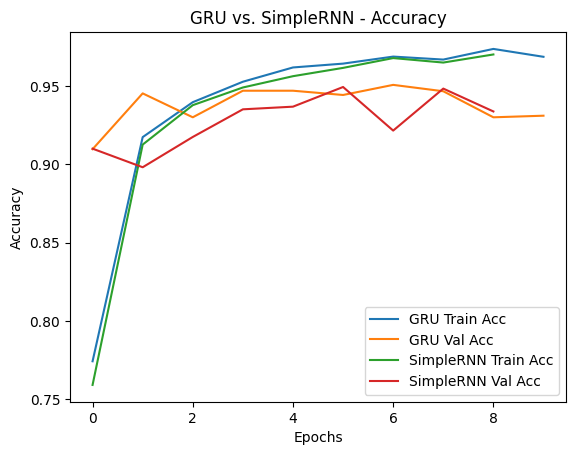

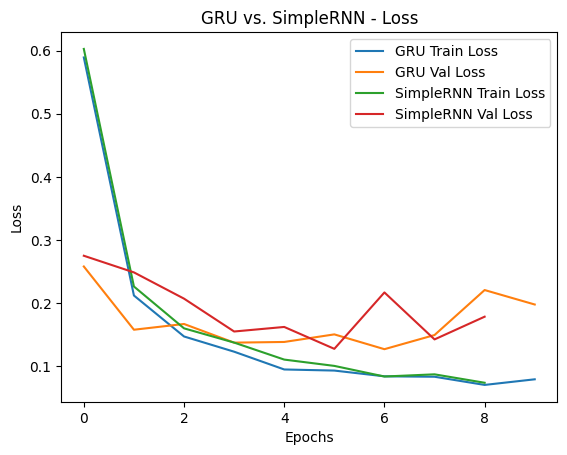

In [10]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.plot(gru_history.history['accuracy'], label="GRU Train Acc")
plt.plot(gru_history.history['val_accuracy'], label="GRU Val Acc")
plt.plot(simplernn_history.history['accuracy'], label="SimpleRNN Train Acc")
plt.plot(simplernn_history.history['val_accuracy'], label="SimpleRNN Val Acc")
plt.title("GRU vs. SimpleRNN - Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Plot Loss
plt.plot(gru_history.history['loss'], label="GRU Train Loss")
plt.plot(gru_history.history['val_loss'], label="GRU Val Loss")
plt.plot(simplernn_history.history['loss'], label="SimpleRNN Train Loss")
plt.plot(simplernn_history.history['val_loss'], label="SimpleRNN Val Loss")
plt.title("GRU vs. SimpleRNN - Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
